In [1]:
import numpy as np
import matplotlib.pyplot as plt
import standard_atmosphere as sa
from scipy.stats import multivariate_normal

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick

%matplotlib inline

## Case 1: Set a 50x50 domain

In [2]:
# Create a 2d domain
nx = 51
ny = 51
#nz = 31
Lx = 12.5
Ly = 12.5
#H = 9

x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

psi_ig = 10
psi = np.ones((nx, ny)) * psi_ig

sigma2 = (dx/dy) **2
xs, ys = np.meshgrid(x, y, indexing='ij')

In [3]:
# Calculate coefficients
r_earth = 6371e3
omega = 7.292E-5
lat = 30 + y
lat_rad = np.deg2rad(lat)
f0 = 2 * omega * (np.sin(lat_rad[0]) + np.sin(lat_rad[-1]))/2
dellambda2 = (r_earth * dy * (np.pi/180.))**2 
relax = 1.9


A1 = np.zeros(len(lat))
A2 = np.zeros(len(lat))
A3 = np.zeros(len(lat))
A4 = np.zeros(len(lat))
A5 = np.zeros(len(lat))

for j in range(1, len(lat)-1):

    coslat_moh =  (np.cos(lat_rad[j]) + np.cos(lat_rad[j-1]))/2
    coslat_poh =  (np.cos(lat_rad[j]) + np.cos(lat_rad[j+1]))/2
    coslat = np.cos(lat_rad[j])


    A1[j] =  coslat_moh / coslat * sigma2
    A2[j] = 1 / (coslat ** 2)
    A3[j] = - ((2/(coslat ** 2)) + sigma2 / coslat * (coslat_moh + coslat_poh))
    A4[j] = A2[j]
    A5[j] = sigma2 * coslat_poh / coslat


In [4]:
# Create a PV perturbation 
radius = 7
q_prime = np.zeros((nx, ny)) 

''' (x0, y0, z0) : coordinates of center of circle inside A. '''
x0, y0 = 25, 25

for m in range(x0-radius, x0+radius+1):
    for n in range(y0-radius, y0+radius+1):
        deb = radius**2 - abs(x0-m)**2 - abs(y0-n)**2
        if (deb)>=0: 
            q_prime[m,n] = 1e-3
            
            
xc = 25    # i coordinate of vortex in gridpoint space
yc = 25    # j coordinate of vortex in gridpoint space
#zc = 9  # k coordinate of vortex in gridpoint space

qc = 1e-5
#PV perturbation
for m in range(nx):
    for n in range(ny):
        q_prime[m,n] = qc * np.exp(-((m - xc) ** 2. + (n - yc) ** 2.) /100.)



In [5]:
# SOR
threshold= 1.e-6        # value of error threshold
max_iters = 500

psi_ig = 10
psi = np.ones((nx, ny)) * psi_ig
for iteration in range(max_iters):
    error = 0
    for i in np.arange(1,nx-1):
        for j in np.arange(1,ny-1):
            # interior points
            res = A1[j]*psi[i,j-1]+A2[j]*psi[i-1,j]+A3[j]*psi[i,j]+A4[j]*psi[i+1,j]+A5[j]*psi[i,j+1]-q_prime[i,j]*dellambda2      # calculation of residual     
            psi[i,j] = psi[i,j] - relax*res/A3[j]    # calculation of stream function
            
            error = error + abs(res)

            
        # if error threshold is met, break out of loop
        ave_err = error/((nx-2)*(ny-2))
    if( ave_err < threshold):      # error threshold, average absolute error must be less than specified
        print('amount of error:')
        print('got here: ',ave_err, iteration)
        break
        
        # number of iterations until convergence
print('number of iterations = ', ave_err, iteration)  

amount of error:
got here:  9.770145974384273e-07 233
number of iterations =  9.770145974384273e-07 233


Text(0.5, 1.0, 'SOR-determined streamfunction')

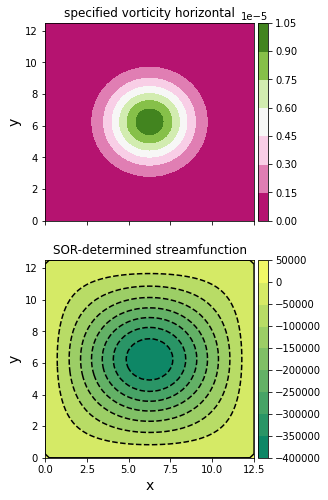

In [6]:
# Plot figures
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,8), sharex=True)
cs = axes[0].contourf(xs,ys,q_prime,cmap='PiYG') 
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
#cs = axes[0].contour(xs[:,:,10],ys[:,:,10],q_prime[:,:,10],colors='black')
axes[0].set_title('specified vorticity horizontal')
axes[0].set_ylabel('y',fontsize=14)
     

cs = axes[1].contourf(xs,ys,psi,cmap='summer') 
axes[1].set_ylabel('y',fontsize=14)
axes[1].set_xlabel('x',fontsize=14)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
cs = axes[1].contour(xs,ys,psi,colors='k') 
axes[1].set_title('SOR-determined streamfunction')

## Case 2: Set a 50x50x30 domain

In [7]:
# Create a 3d domain
nx = 51
ny = 51
nz = 31
Lx = 12.5
Ly = 12.5
H = 9

x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
z = np.linspace(0, H, nz)

dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

psi_ig = 10
psi = np.ones((nx, ny, nz)) * psi_ig

sigma2 = (dx/dy) **2
xs, ys, zs = np.meshgrid(x, y, z, indexing='ij')


In [23]:
# create a 3d PV perturbation ball, position at the domain center
radius = 7
q_prime = np.zeros((nx, ny, nz)) 

''' (x0, y0, z0) : coordinates of center of circle inside A. '''
x0, y0, z0 = 25, 25, 15

#for m in range(x0-radius, x0+radius+1):
#    for n in range(y0-radius, y0+radius+1):
#        for l in range(z0-radius, z0+radius+1):
#            deb = radius**2 - abs(x0-m)**2 - abs(y0-n)**2 - abs((z0-l))**2
#            if (deb)>=0: 
#                q_prime[m,n,l] = 1e-3
                
                
xc = 25    # i coordinate of vortex in gridpoint space
yc = 25    # j coordinate of vortex in gridpoint space
zc = 15  # k coordinate of vortex in gridpoint space

qc = 1e-5
q_prime_v = np.zeros((nx, ny))
#PV perturbation
for m in range(nx):
    for n in range(ny):
        #for l in range(14, 17):
        q_prime_v[m,n] = qc * np.exp(-((m - xc) ** 2. + (n - yc) ** 2.) /100.)

for l in range(10,21):
    q_prime[:,:,l] = q_prime_v

In [24]:
A1 = np.zeros(len(lat))
A2 = np.zeros(len(lat))
A3 = np.zeros(len(lat))
A4 = np.zeros(len(lat))
A5 = np.zeros(len(lat))

for j in range(1, len(lat)-1):

    coslat_moh =  (np.cos(lat_rad[j]) + np.cos(lat_rad[j-1]))/2
    coslat_poh =  (np.cos(lat_rad[j]) + np.cos(lat_rad[j+1]))/2
    coslat = np.cos(lat_rad[j])


    A1[j] =  coslat_moh / coslat * sigma2
    A2[j] = 1 / (coslat ** 2)
    A3[j] = - ((2/(coslat ** 2)) + sigma2 / coslat * (coslat_moh + coslat_poh))
    A4[j] = A2[j]
    A5[j] = sigma2 * coslat_poh / coslat


In [38]:
# convert altitude to pressure
pres = 101325 * (1 - 2.25569*10**(-5)*z*1000)**5.25616
pres = np.linspace(100000, 70000,31)
# Calculate coefficients
Z_sa, phi_sa, T_sa, S_half_sa = sa.atmos_structure(pres)
dp = pres[1:] - pres[:-1]
#dp = np.append(dp[0], dp)
dpph = np.append(dp, dp[-1])
dpmh = np.append(dp[0], dp)
dppmh = np.append(dp[0], dpph)
dppmh = (dppmh[1:] + dppmh[:-1])/2

S_half_r= 1/S_half_sa
# For purpose of calculate, append the last element of s_r to s+1/2, and the first ahead of s-1/2
Sph_r = np.append(S_half_r, S_half_r[-1])
Smh_r = np.append(S_half_r[0], S_half_r)
A3_s  = - (Smh_r + Sph_r) * f0**2 /dppmh**2 * (dellambda2)
A6 = Smh_r * f0**2 /dpmh**2 * (dellambda2)
A7 = Sph_r * f0**2 /dpph**2 * (dellambda2)

A3i_qgpv = np.zeros((ny, nz))
A3i_qgpv = A3_s[None, :] + A3[:, None]

R = 287.05

# Set temperature perturbation to 0 for now
tmpk_prime = np.ones((nx, ny, nz)) * 0
tmpk_top = (tmpk_prime[:, :, 0] + tmpk_prime[:, :, 1])/2
tmpk_btm = (tmpk_prime[:, :, -1] + tmpk_prime[:, :, -2])/2

In [39]:
# SOR
threshold= 1.e-4        # value of error threshold
error_list = []
psi = np.ones((nx, ny, nz)) * psi_ig
for iteration in range(500):
    if iteration%100 == 0:
        print(iteration)
    psi[:, :, 0] = psi[:, :, 1] - R / pres[0] * tmpk_btm * (-dp[0]) / f0
    psi[:, :, -1] = psi[:, : ,-2] - R / pres[-1] * tmpk_top * dp[-1] / f0
    error = 0
    #for k in range(1, nz-1):
    for k in np.arange(29, 0, -1):
        # check temperature bc later

        for j in range(1, ny-1):
            for i in range(1, nx-1):
                # interior points
                lap = A1[j]*psi[i,j-1,k] + A2[j]*psi[i-1,j,k] + A3[j]*psi[i,j,k] + A4[j]*psi[i+1,j,k] + A5[j]*psi[i,j+1,k]      # calculation of residual
                stch = A6[k]*psi[i,j,k-1] + A3_s[k]*psi[i,j,k] + A7[k]*psi[i,j,k+1]
                res = lap + stch - q_prime[i, j, k]*dellambda2  # Why is the dellambda2 not appear in front of the stretching term
                #try:
                psi[i, j, k] = psi[i, j, k] - 1.9*res/A3i_qgpv[j, k]    # calculation of stream function
                #except IndexError:
                #    print(i, j ,k)
                error = error + abs(res)


            # if error threshold is met, break out of loop        
        unit_error = error/((nx-2)*(ny-2)*(nz-2))
        error_list.append(unit_error)
    if (unit_error < threshold):                
        print('amount of error:', iteration)
        print('got here: ', unit_error , iteration)
        break

        # number of iterations until convergence
print('number of iterations = ', iteration, unit_error)
np.save('3d_ideal_psi',psi)

0
100
200
300
400
number of iterations =  499 1.407980404515057


Text(0.5, 1.0, 'residual')

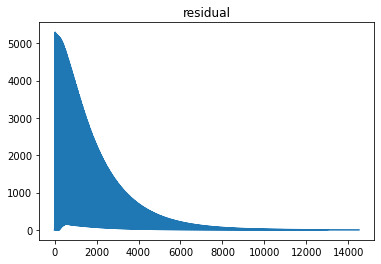

In [40]:
plt.plot(error_list)
plt.title('residual')
#print(error_list)

Text(0.5, 1.0, 'SOR-determined streamfunction')

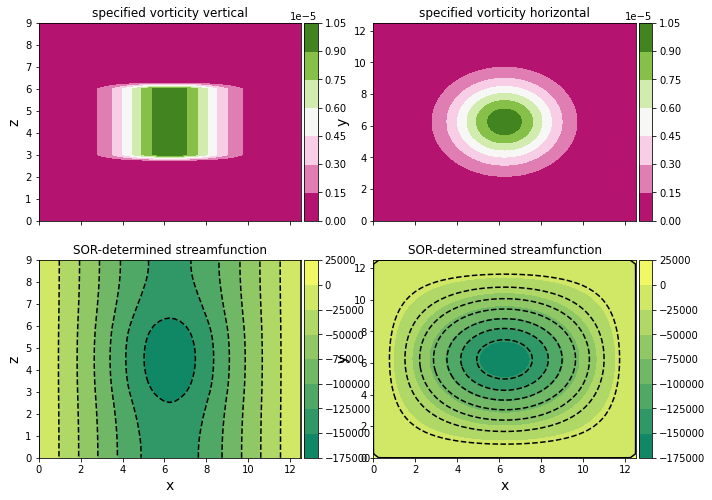

In [41]:
# Plot figures
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,8), sharex=True)
cs = axes[0,1].contourf(xs[:,:,10],ys[:,:,10],q_prime[:,:,15],cmap='PiYG') 
divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
#cs = axes[0].contour(xs[:,:,10],ys[:,:,10],q_prime[:,:,10],colors='black')
axes[0,1].set_title('specified vorticity horizontal')
axes[0,1].set_ylabel('y',fontsize=14)
    

psi_mean = np.mean(psi[:,:,1].flatten())
cs = axes[1,0].contourf(xs[:,25,:],zs[:,25,:],psi[:,25,:],cmap='summer') 
axes[1,0].set_ylabel('z',fontsize=14)
axes[1,0].set_xlabel('x',fontsize=14)
divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
cs = axes[1,0].contour(xs[:,25,:],zs[:,25,:],psi[:,25,:],colors='k') 
axes[1,0].set_title('SOR-determined streamfunction')

cs = axes[0,0].contourf(xs[:,25,:],zs[:,25,:],q_prime[:,25,:],cmap='PiYG') 
divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
#cs = axes[0].contour(xs[:,:,10],ys[:,:,10],q_prime[:,:,10],colors='black')
axes[0,0].set_title('specified vorticity vertical')
axes[0,0].set_ylabel('z',fontsize=14)
     

cs = axes[1,1].contourf(xs[:,:,10],ys[:,:,10],psi[:,:,15],cmap='summer') 
axes[1,1].set_ylabel('y',fontsize=14)
axes[1,1].set_xlabel('x',fontsize=14)
divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
cs = axes[1,1].contour(xs[:,:,10],ys[:,:,10],psi[:,:,10],colors='k') 
axes[1,1].set_title('SOR-determined streamfunction')

## Case 3 warm temperature anomaly at the bottom

The sign is wrong, should have negative streamfunction value, maybe because dp is negative?

In [42]:
# Create a warm gaussian temperature perturbation at the center of surface layer only
tx, ty = np.mgrid[0.:12.5:51j, 0:12.5:51j]
txy = np.column_stack([tx.flat, ty.flat])

mu = np.array([6.25, 6.25])
sigma = np.array([2, 2])
covariance = np.diag(sigma**2)

temp_pos = multivariate_normal.pdf(txy, mean=mu, cov=covariance)
temp_pos = temp_pos.reshape(tx.shape) * 100


tmpk_prime = np.ones((nx, ny, nz)) * 0
tmpk_prime[:, :, 0] = temp_pos
tmpk_top = (tmpk_prime[:, :, -1] + tmpk_prime[:, :, -2])/2
tmpk_btm = (tmpk_prime[:, :, 0] + tmpk_prime[:, :, 1])/2

# Set interior q' to 0
q_prime = np.zeros((nx, ny, nz)) 

In [43]:
# SOR

threshold= 1.e-10        # value of error threshold
error_list = []
psi = np.ones((nx, ny, nz)) * psi_ig
for iteration in range(50):
    if iteration%100 == 0:
        print(iteration)
    '''
    We infer psi at the top and the bottom from the interior grid information
    '''
    psi[:, :, 0] = psi[:, :, 1] - R / pres[0] * tmpk_btm * (-dp[0]) / f0
    psi[:, :, -1] = psi[:, : ,-2] - R / pres[-1] * tmpk_top * dp[-1] / f0
    error = 0
    for k in range(1, nz-1):
        # check temperature bc later

        for j in range(1, ny-1):
            for i in range(1, nx-1):
                # interior points
                lap = A1[j]*psi[i,j-1,k] + A2[j]*psi[i-1,j,k] + A3[j]*psi[i,j,k] + A4[j]*psi[i+1,j,k] + A5[j]*psi[i,j+1,k]      # calculation of residual
                stch = A6[k]*psi[i,j,k-1] + A3_s[k]*psi[i,j,k] + A7[k]*psi[i,j,k+1]
                res = lap + stch - q_prime[i, j, k]*dellambda2  # Why is the dellambda2 not appear in front of the stretching term
                #try:
                psi[i, j, k] = psi[i, j, k] - 1.9*res/A3i_qgpv[j, k]    # calculation of stream function
                #except IndexError:
                #    print(i, j ,k)
                error = error + abs(res)


            # if error threshold is met, break out of loop
        
        unit_error = error/((nx-2)*(ny-2)*(nz-2))
        error_list.append(unit_error)
    if (unit_error < threshold):                
        print('amount of error:', iteration)
        print('got here: ', unit_error , iteration)
        break

        # number of iterations until convergence
print('number of iterations = ', iteration, unit_error)

0
hmm . . . number of iterations =  49 3.492674409266704e-07


Text(0.5, 1.0, 'residual')

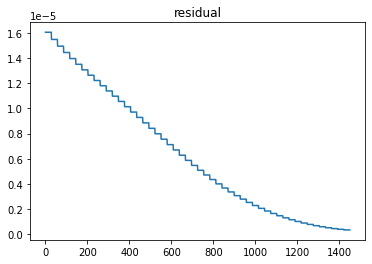

In [44]:
plt.plot(error_list)
plt.title('residual')

Text(0, 0.5, 'z')

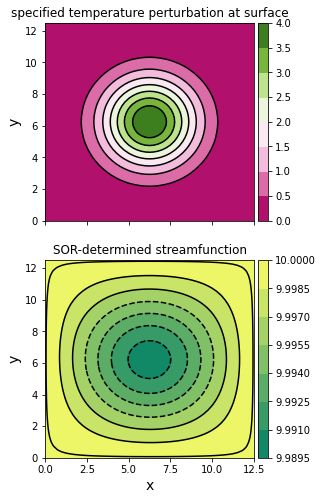

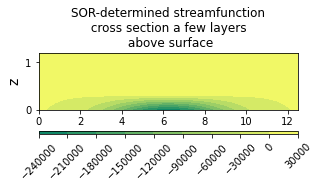

In [45]:
# plot figures
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,8), sharex=True)
cs = axes[0].contourf(xs[:,:,10],ys[:,:,10],tmpk_prime[:,:,0],cmap='PiYG') 
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
cs = axes[0].contour(xs[:,:,10],ys[:,:,10],tmpk_prime[:,:,0],colors='black')
axes[0].set_title('specified temperature perturbation at surface')
axes[0].set_ylabel('y',fontsize=14)
     

psi_mean = np.mean(psi[:,:,1].flatten())
cs = axes[1].contourf(xs[:,:,0],ys[:,:,1],psi[:,:,1],cmap='summer') 
axes[1].set_ylabel('y',fontsize=14)
axes[1].set_xlabel('x',fontsize=14)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
cs = axes[1].contour(xs[:,:,0],ys[:,:,1],psi[:,:,1]-psi_mean, colors='k') 
axes[1].set_title('SOR-determined streamfunction')


fig, ax = plt.subplots(figsize=(4.65,1.5))
psi_mean = np.mean(psi[:,25,:].flatten())
cs = ax.contourf(xs[:,25,:5],zs[:,25,:5],psi[:,25,:5]-psi_mean,cmap='summer')#,levels=[psi_ig-.6,psib-.5,psib-.4,psib-.3,psib-.2,psib-.1,psib,psib+.1,psib+.2,psib+.3,psib+.4,psib+.5,psib+.6])
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.3)
plt.colorbar(cs, cax=cax, orientation='horizontal')
plt.xticks(rotation=45)
ax.set_title(f'SOR-determined streamfunction\n cross section a few layers \n above surface')
ax.set_ylabel('z',fontsize=14)
#ax.set_xlabel('x',fontsize=14)

## Case 4 Cold temperature anomaly at the top

In [12]:
# Create a cold gaussian temperature perturbation at the center of top layer only

tx, ty = np.mgrid[0.:12.5:51j, 0:12.5:51j]
txy = np.column_stack([tx.flat, ty.flat])

mu = np.array([6.25, 6.25])
sigma = np.array([2, 2])
covariance = np.diag(sigma**2)

temp_pos = multivariate_normal.pdf(txy, mean=mu, cov=covariance)
temp_pos = temp_pos.reshape(tx.shape) * 100
temp_neg = - temp_pos

tmpk_prime = np.ones((nx, ny, nz)) * 0
tmpk_prime[:, :, -1] = temp_neg
tmpk_top = (tmpk_prime[:, :, -1] + tmpk_prime[:, :, -2])/2
tmpk_btm = (tmpk_prime[:, :, 0] + tmpk_prime[:, :, 1])/2

# set interior q' to 0
q_prime = np.zeros((nx, ny, nz))

In [16]:
# SOR
threshold= 1.e-6        # value of error threshold
error_list = []
psi = np.ones((nx, ny, nz)) * psi_ig
for iteration in range(50):
    if iteration%100 == 0:
        print(iteration)
    psi[:, :, 0] = psi[:, :, 1] - R / pres[0] * tmpk_btm * (-dp[0]) / f0
    psi[:, :, -1] = psi[:, : ,-2] - R / pres[-1] * tmpk_top * dp[-1] / f0
    error = 0
    for k in np.arange(29, 1, -1):
        '''
        It's reversed here, for a better effect.
        '''
        # check temperature bc later

        for j in range(1, ny-1):
            for i in range(1, nx-1):
                # interior points
                lap = A1[j]*psi[i,j-1,k] + A2[j]*psi[i-1,j,k] + A3[j]*psi[i,j,k] + A4[j]*psi[i+1,j,k] + A5[j]*psi[i,j+1,k]      # calculation of residual
                stch = A6[k]*psi[i,j,k-1] + A3_s[k]*psi[i,j,k] + A7[k]*psi[i,j,k+1]
                res = lap + stch - q_prime[i, j, k]*dellambda2  # Why is the dellambda2 not appear in front of the stretching term
                #try:
                psi[i, j, k] = psi[i, j, k] - 1.9*res/A3i_qgpv[j, k]    # calculation of stream function
                #except IndexError:
                #    print(i, j ,k)
                error = error + abs(res)


            # if error threshold is met, break out of loop
        
        unit_error = error/((nx-2)*(ny-2)*(nz-2))
        error_list.append(unit_error)
    if (unit_error < threshold):                
        print('amount of error:', iteration)
        print('got here: ', unit_error , iteration)
        break

        # number of iterations until convergence
print('hmm . . . number of iterations = ', iteration, unit_error)

0
amount of error: 42
got here:  8.868742094393276e-07 42
hmm . . . number of iterations =  42 8.868742094393276e-07


Text(0.5, 1.0, 'residual')

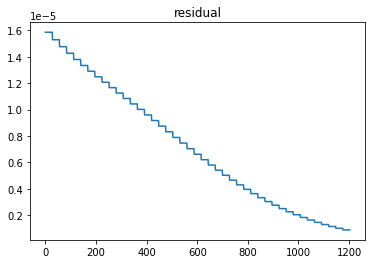

In [17]:
plt.plot(error_list)
plt.title('residual')

Text(0, 0.5, 'z')

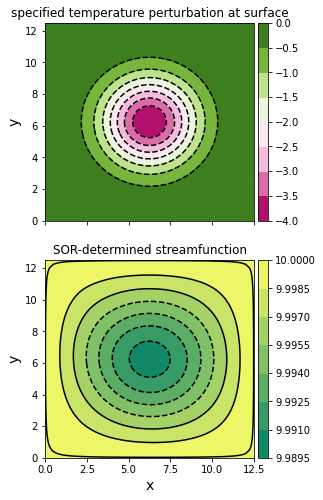

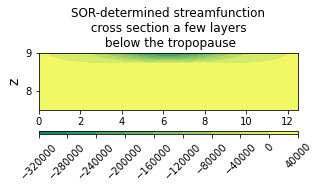

In [41]:
# plot figures
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,8), sharex=True)
cs = axes[0].contourf(xs[:,:,10],ys[:,:,10],tmpk_prime[:,:,-1],cmap='PiYG') 
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
cs = axes[0].contour(xs[:,:,10],ys[:,:,10],tmpk_prime[:,:,-1],colors='black')
axes[0].set_title('specified temperature perturbation at surface')
axes[0].set_ylabel('y',fontsize=14)
     

psi_mean = np.mean(psi[:,:,-2].flatten())
cs = axes[1].contourf(xs[:,:,0],ys[:,:,0],psi[:,:,-2],cmap='summer') 
axes[1].set_ylabel('y',fontsize=14)
axes[1].set_xlabel('x',fontsize=14)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cs, cax=cax, orientation='vertical')
cs = axes[1].contour(xs[:,:,0],ys[:,:,1],psi[:,:,-2]-psi_mean, colors='k') 
axes[1].set_title('SOR-determined streamfunction')


fig, ax = plt.subplots(figsize=(4.65,1.5))
psi_mean = np.mean(psi[:,25,:].flatten())
cs = ax.contourf(xs[:,25,-6:],zs[:,25,-6:],psi[:,25,-6:]-psi_mean,cmap='summer')#,levels=[psi_ig-.6,psib-.5,psib-.4,psib-.3,psib-.2,psib-.1,psib,psib+.1,psib+.2,psib+.3,psib+.4,psib+.5,psib+.6])
#plt.colorbar(cs, orientation='horizontal')
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.3)
plt.colorbar(cs, cax=cax, orientation='horizontal')
plt.xticks(rotation=45)
#cs = ax.contour(xs[:,25,:5],zs[:,25,:5],psi[:,25,:5]-psi_mean,colors='k')#,levels=[psi_ig-.6,psib-.5,psib-.4,psib-.3,psib-.2,psib-.1,psib,psib+.1,psib+.2,psib+.3,psib+.4,psib+.5,psib+.6])
ax.set_title(f'SOR-determined streamfunction\n cross section a few layers \n below the tropopause')
ax.set_ylabel('z',fontsize=14)
#ax.set_xlabel('x',fontsize=14)